<a href="https://colab.research.google.com/github/faustocristiano/Contador-de-palavras-repetidas/blob/master/Classificador_semanal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificador de Comportamento padrão

Este código auxilia a classificação de trechos de 4 horas das séries temporais em trechos de comportamento ideal e anormal.

Para classificar um trecho como ideal, deve-se responder 's', para classificar como anormal 'n' e caso o trecho apresente um comportamento de erro de leitura, qualquer outro input fará com que o trecho não seja salvo.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.widgets import Button

from google.colab import drive
drive.mount('/content/drive')
import os
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import minmax_scale
from datetime import timedelta, datetime
!pip install arch
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller
from time import sleep

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


tipo:
* 1 - Ambiente
* 2 - Veículo 
* 3 - Camara Fria
* 4 - Ultra Freezer
* 5 - Geladeira
* 6 - Freezer
* 7 - Caixa Térmica

#Metodologia de Classificação

O seguinte script gera uma série temporal selecionando intervalos de 4 horas para a serie temporal. Ele plota um gráfico dos dados dessas 4 horas para que o usuário possa avaliar manualmente.

O usuário deve classificar o gráfico como "ideal", "anômalo" ou "passar" (caso não queira salvar e imprimir as próximas 4 horas).

Se o gráfico for classificado como "ideal" ou "anômalo", o período de 4 horas correspondente será salvo em uma pasta de acordo com sua classificação. Após o salvamento, o script avançará 6 dias na série temporal e plotará os próximos 4 horas para que o usuário possa realizar a classificação novamente.

Esse processo será repetido até o final da série temporal ou um ano de dados percorridos, apos isso avança para o proximo sensor.

Aqui estão algumas considerações adicionais para fazer a classificação:


- Para classificar o gráfico como "ideal", ele deve seguir um período identificável padrão, como por exemplo, uma sequência de barbatanas de tubarão, e os valores máximos e mínimos devem ter uma padronização sem muita divergência.


- Para classificar o gráfico como "anômalo", ele deve apresentar uma variação de temperatura brusca, de forma que seja impossível identificar um período padrão da série temporal, como por exemplo, abertura de porta, ou não seguir um padrão nos valores máximos e mínimos, ou ter alguma tendência de curva fora do padrão.

In [ ]:
# Tipo de equipamento a analisar
tipo = 3



# Especifique aqui o diretório de entrada, deve ser um csv com os arquivos que foram classificados manualmente
classificados = os.path.join('drive/Shareddrives/2023 - INSIGHTS - IFSC+Sensorweb/Datasets Sensorweb/ClassificadosManualmente_iguais.csv') # usar no drive

In [ ]:
# Especifique aqui o diretório para onde as curvas ideais devem ir 
diretorio_saida = 'drive/Shareddrives/2023 - INSIGHTS - IFSC+Sensorweb/Datasets Sensorweb/CurvasIdeais/'

if tipo == 1:
  diretorio_saida = diretorio_saida+"Ambiente/"
elif tipo ==2:
  diretorio_saida = diretorio_saida+"Veiculo/"
elif tipo ==3:
  diretorio_saida = diretorio_saida+"Camara/"
elif tipo ==4:
  diretorio_saida = diretorio_saida+"Ultra/"
elif tipo ==5:
  diretorio_saida = diretorio_saida+"Geladeira/"
elif tipo ==6:
  diretorio_saida = diretorio_saida+"Freezer/"
elif tipo ==7:
  diretorio_saida = diretorio_saida+"Caixa/"

### Verificando se algum dos arquivos ja foi processado

A função a seguir vai verificar se os arquivos do diretorio recebido como parametro ja foram processados. Essa função retorna uma lista que contêm o nome dos arquivos que devem ser processados. Utilizando como nome do arquivo, seu nome que está na coluna nome.

In [ ]:
def verifica_arquivo_processado(diretorio_csv, arquivo):
    nomes_processados = []
    for diretorio in os.listdir(diretorio_csv):
        for arquivos in os.listdir(diretorio_csv+diretorio):
          nomes_processados.append(arquivos)
    nome_arquivo = arquivo.split("/")[-1].split(".csv")[0]

    arquivos_a_processar = []

    for nome in nomes_processados:
      if nome_arquivo not in nome:
        print("True")
        return True
      else:
        print("False")
        return False
    return True



In [ ]:
def busca_Horario(TS,data_ini=0):

    if data_ini == 0:
      data_ini = TS['Iniciado em'].max() - timedelta(days=1)
      data_ini = data_ini.replace(hour=0, minute=0, second=0, microsecond=0)

    data_ini = data_ini - timedelta(days=6,hours=6) #Gerar aleatoriedade nos dados de entrada
    data_fim = data_ini + timedelta(hours=4)

    while True:
      try:
        TS_periodo = TS.loc[((TS['Iniciado em'] >= data_ini) & (TS['Iniciado em'] <= data_fim))]
        TS_periodo = TS_periodo.dropna()
        TS_periodo = TS_periodo.reset_index()


      except:
        return 'p', TS_periodo, data_ini, False

      if TS_periodo.shape[0] > 20:
        fig, (ax1)  = plt.subplots(1, 1,sharey='row',figsize=(9, 6))
        ax1.set(xlabel='Tempo',ylabel= 'Temperatura')
        ax1.plot( TS_periodo['Iniciado em'], TS_periodo['Valor'])
        plt.show()
        sleep(1)
        resposta = input("A série é válida? (s/n/p) \n")
      else:
        resposta = 'p'
      if resposta in 'sn':
        if data_ini > TS['Iniciado em'].max() - timedelta(days=365) and data_ini >= TS['Iniciado em'].min():
          return resposta, TS_periodo, data_ini, True
        else:
          return resposta, TS_periodo, data_ini, False

      else:
        data_fim = data_fim - timedelta(hours=4)
        data_ini = data_ini - timedelta(hours=4)


In [ ]:
def obtem_sensor(tipo: int) ->np.ndarray:
    sensores = pd.read_csv(classificados)
    filtrado = sensores[sensores['tipo'] == tipo]
    return filtrado['diretorio'].values

In [ ]:
def verifica_Ultimo_Timestamp(diretorio_saida, arquivo):
    nomes_processados = []
    for diretorio in os.listdir(diretorio_saida):
        for arquivos in os.listdir(diretorio_saida+diretorio):
          nomes_processados.append(arquivos)
    nome_arquivo = arquivo.split("/")[-1].split('.csv')[0]
  
    arquivos_deste_sensor = []
    for nome in nomes_processados:
        if nome_arquivo in nome:
          arquivos_deste_sensor.append(nome)

    sensor = min(arquivos_deste_sensor, key=lambda x: datetime.strptime(x.split("_")[-1].split(".csv")[0], "%Y%m%d%H%M%S"))

    sensor = sensor.split("_")[-1].split(".csv")[0]

    data_ini = datetime.strptime(sensor, "%Y%m%d%H%M%S")

    return data_ini

drive/Shareddrives/2023 - INSIGHTS - IFSC+Sensorweb/Datasets Sensorweb/Ifsc1/Ifsc1Limpos/Sensor - [Cmara de Carnes]  1 SS ? TT ? Torre Tamandar_limpo.csv


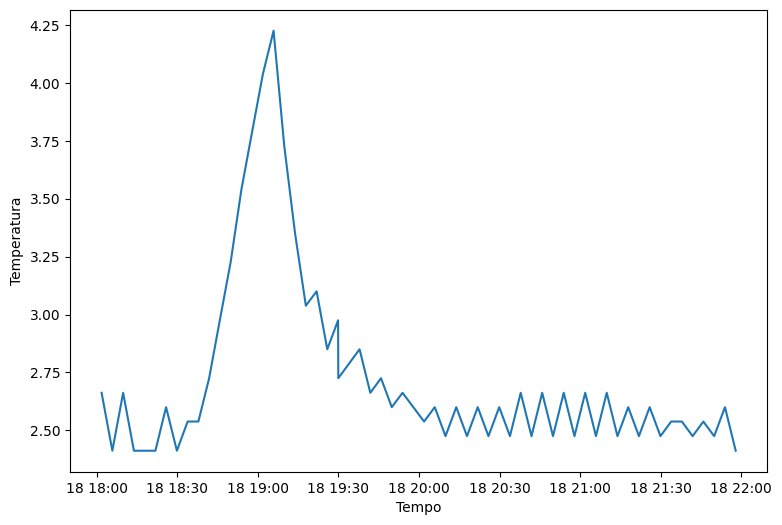

A série é válida? (s/n/p) 
n
salvando
drive/Shareddrives/2023 - INSIGHTS - IFSC+Sensorweb/Datasets Sensorweb/CurvasIdeais/Camara/anormal/Sensor - [Cmara de Carnes]  1 SS ? TT ? Torre Tamandar_limpo_20221218180000.csv


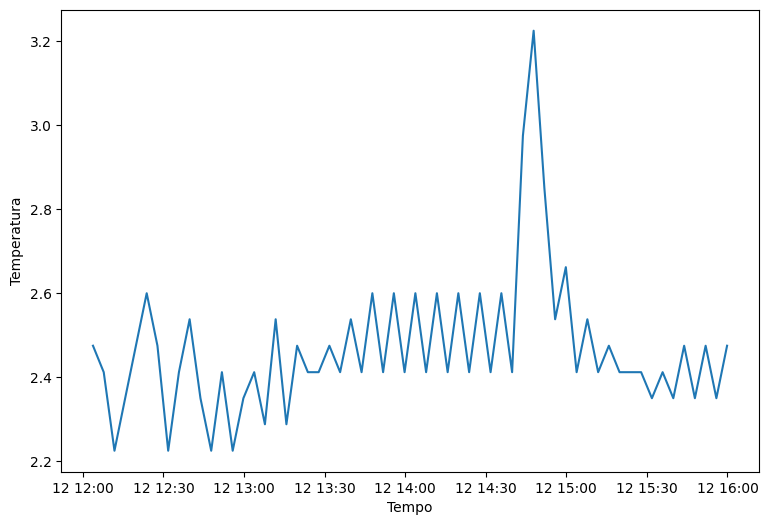

A série é válida? (s/n/p) 
n
salvando
drive/Shareddrives/2023 - INSIGHTS - IFSC+Sensorweb/Datasets Sensorweb/CurvasIdeais/Camara/anormal/Sensor - [Cmara de Carnes]  1 SS ? TT ? Torre Tamandar_limpo_20221212120000.csv


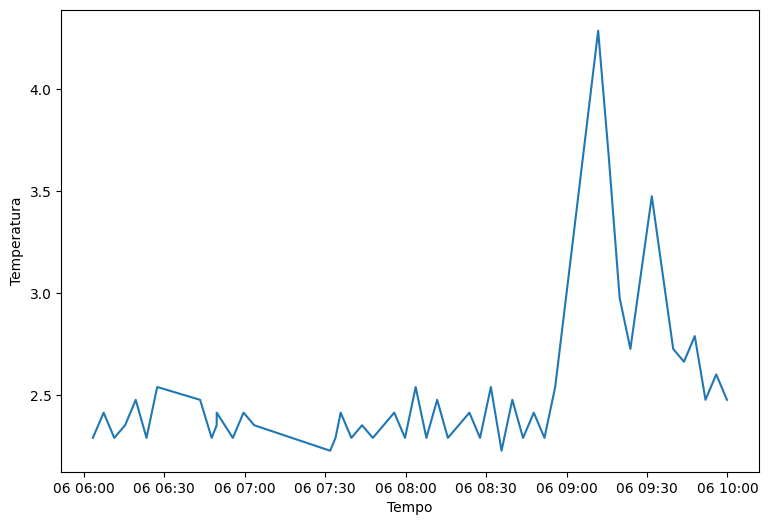

A série é válida? (s/n/p) 
n
salvando
drive/Shareddrives/2023 - INSIGHTS - IFSC+Sensorweb/Datasets Sensorweb/CurvasIdeais/Camara/anormal/Sensor - [Cmara de Carnes]  1 SS ? TT ? Torre Tamandar_limpo_20221206060000.csv


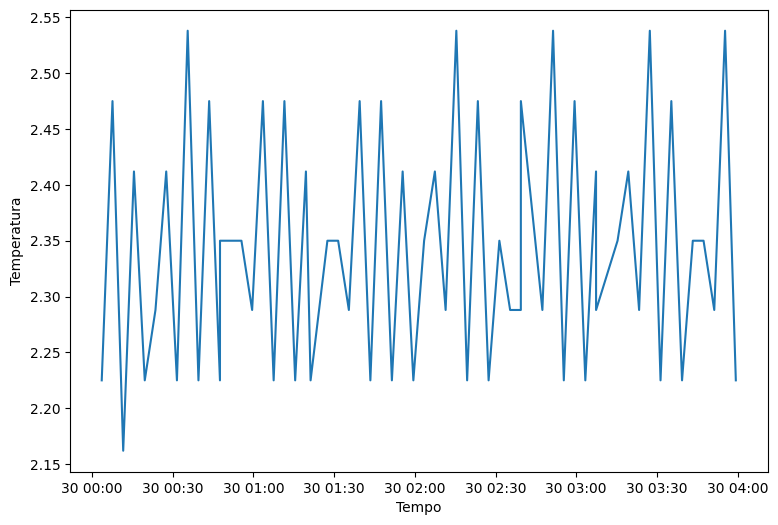

In [ ]:
sensores = obtem_sensor(tipo)

for arquivo in sensores:

    df_read = pd.read_csv(arquivo, parse_dates=['Iniciado em'], encoding = "ISO-8859-1")
    print(arquivo)

    # Caso seja a primeira vez classificando o arquivo
    if verifica_arquivo_processado(diretorio_saida, arquivo):
       
        resposta, periodo, data_ini, continua = busca_Horario(df_read)
    
    # Caso esteja continuando uma classificação anterior
    else:
        data_ini = verifica_Ultimo_Timestamp(diretorio_saida, arquivo)

        resposta, periodo, data_ini, continua = busca_Horario(df_read,data_ini)


    while continua:
      nome_arquivo = arquivo.split("/")[-1]
      nome_arquivo = nome_arquivo.split('.csv')[0] + "_" + data_ini.strftime("%Y%m%d%H%M%S")
      periodo.drop(['index'], axis='columns', inplace=True)
      
      if resposta == 's':
          print('salvando')
          saida = diretorio_saida+"ideal/"+nome_arquivo +'.csv'
          print(saida)
          periodo.to_csv(saida, mode='w', index=False)
      elif resposta == 'n':
          print('salvando')
          saida = diretorio_saida+"anormal/"+nome_arquivo +'.csv'
          print(saida)
          periodo.to_csv(saida, index=False)


      resposta, periodo, data_ini, continua = busca_Horario(df_read,data_ini)
    
